In [3]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide_toggle()

## Steinmetz data

In [4]:
# Import libraries
import numpy as np
import os, requests
from matplotlib import pyplot as plt

In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [5]:
import pandas as pd

In [6]:
# For visualization
import matplotlib.cm as cm
colormap = cm.viridis

In [7]:
#@title import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [8]:
# Load Data
fname = []
for j in range(3):
    fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
    if not os.path.isfile(fname[j]):
        try:
            r = requests.get(url[j])
        except requests.ConnectionError:
            print("!!! Failed to download data !!!")
        else:        
            if r.status_code != requests.codes.ok:
                print("!!! Failed to download data !!!")
            else:
                with open(fname[j], "wb") as fid:
                    fid.write(r.content)

In [9]:
#@title Data loading
alldat = np.array([])
for j in range(len(fname)):
    alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx.
dat = alldat[11]
print(dat.keys())

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


### Data structure check

In [10]:
dat['spks'].shape # neurons x trials x time bins

(698, 340, 250)

In [11]:
# for i in range(39):
#     print(alldat[i]['mouse_name'])

## Group brain regions

In [14]:
def load_data(n_session):
    dat = alldat[n_session]

    # groupings of brain regions
    regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
    brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                    ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                    ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                    ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                    ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                    ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                    ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                    ]

    nareas = 4 # only the top 4 regions are in this particular mouse
    NN = len(dat['brain_area']) # number of neurons
    barea = nareas * np.ones(NN, ) # last one is "other"
    for j in range(nareas):
        barea[np.isin(dat['brain_area'], brain_groups[j])] = j # assign a number to each region
        
    return dat, barea, NN, regions, brain_groups, nareas

dat, barea, NN, regions, brain_groups, nareas = load_data(11)

In [15]:
brain_groups[2]

['CA', 'CA1', 'CA2', 'CA3', 'DG', 'SUB', 'POST']

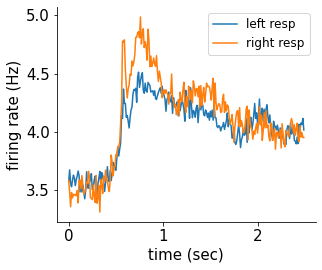

In [16]:
#@title basic plots of population average
dt = dat['bin_size'] # binning at 10 ms
NT = dat['spks'].shape[-1]

ax = plt.subplot(1,5,1)
response = dat['response'] # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,response>=0].mean(axis=(0,1)), label='left resp') # left responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,response<0].mean(axis=(0,1)), label='right resp') # right responses
# plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,vis_right>0].mean(axis=(0,1))) # stimulus on the right
# plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,vis_right==0].mean(axis=(0,1))) # no stimulus on the right

# plt.legend(['left resp', 'right resp', 'right stim', 'no right stim'], fontsize=12)
plt.legend(fontsize=12)
ax.set(xlabel  = 'time (sec)', ylabel = 'firing rate (Hz)');
plt.show()

hide_toggle()

In [17]:
dat['spks'][barea==1][:,response>=0].shape

(155, 199, 250)

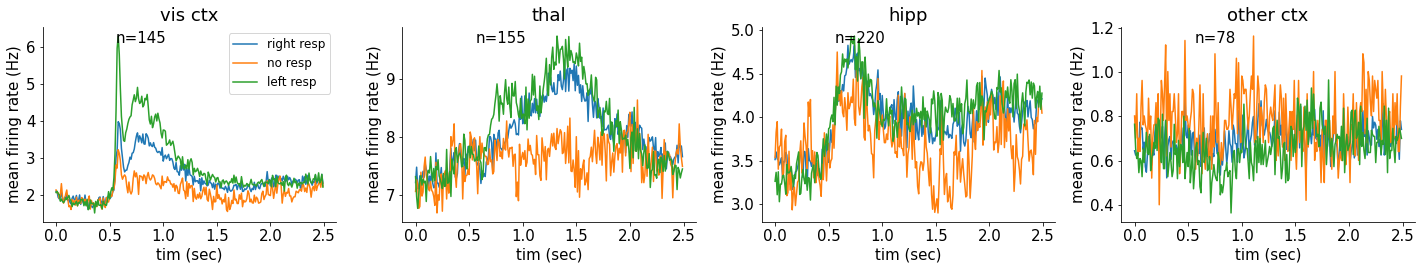

In [18]:
# plots by brain region and responses
for j in range(nareas):
    ax = plt.subplot(1,nareas,j+1)
  
    plt.plot(dt * np.arange(NT), 1/dt *  dat['spks'][barea==j][:,response>=0].mean(axis=(0,1)))
    plt.plot(dt * np.arange(NT), 1/dt *  dat['spks'][barea==j][:,response==0].mean(axis=(0,1)))
    plt.plot(dt * np.arange(NT), 1/dt *  dat['spks'][barea==j][:,response<0].mean(axis=(0,1)))  
    plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)

    if j==0:
        plt.legend(['right resp','no resp', 'left resp'], fontsize=12)
    ax.set(xlabel = 'tim (sec)', ylabel = 'mean firing rate (Hz)', title = regions[j])

hide_toggle()

## Contrast difference

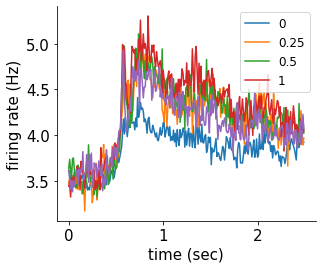

In [19]:
l_cont = dat['contrast_left']
r_cont = dat['contrast_right']
# print(l_cont)

# neural activity by task difficulties
dat['spks'][:,np.abs(l_cont-r_cont)==0].shape
dat['spks'][:,np.abs(l_cont-r_cont)==0.25].shape
dat['spks'][:,np.abs(l_cont-r_cont)==0.5].shape
dat['spks'][:,np.abs(l_cont-r_cont)==0.75].shape
dat['spks'][:,np.abs(l_cont-r_cont)==1].shape

ax = plt.subplot(1,5,1)
# vis_right = dat['contrast_right'] # 0 - low - high
# vis_left = dat['contrast_left'] # 0 - low - high

plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,np.abs(l_cont-r_cont)==0].mean(axis=(0,1))) # difference 0
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,np.abs(l_cont-r_cont)==0.25].mean(axis=(0,1))) # difference 0.25
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,np.abs(l_cont-r_cont)==0.5].mean(axis=(0,1))) # difference 0.5
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,np.abs(l_cont-r_cont)==0.75].mean(axis=(0,1))) # difference 0.75
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,np.abs(l_cont-r_cont)==1].mean(axis=(0,1))) # difference 1

plt.legend(['0', '0.25', '0.5', '1'], fontsize=12)
# plt.legend(fontsize=12)
ax.set(xlabel  = 'time (sec)', ylabel = 'firing rate (Hz)');
plt.show()

hide_toggle()

In [20]:
def get_contrast_diff(n_session):
    dat, barea, NN, regions, brain_groups, nareas = load_data(n_session)

    dt = dat['bin_size'] # binning at 10 ms
    NT = dat['spks'].shape[-1]

    l_cont = dat['contrast_left']
    r_cont = dat['contrast_right']
    
    d_cont = np.abs(l_cont - r_cont)
    dd_cont = np.diff(d_cont)
    ddcont = np.insert(dd_cont, 0, 0)

    return dt, NT, d_cont, dd_cont, ddcont

# dt, NT, d_cont, dd_cont, ddcont = get_contrast_diff(11)

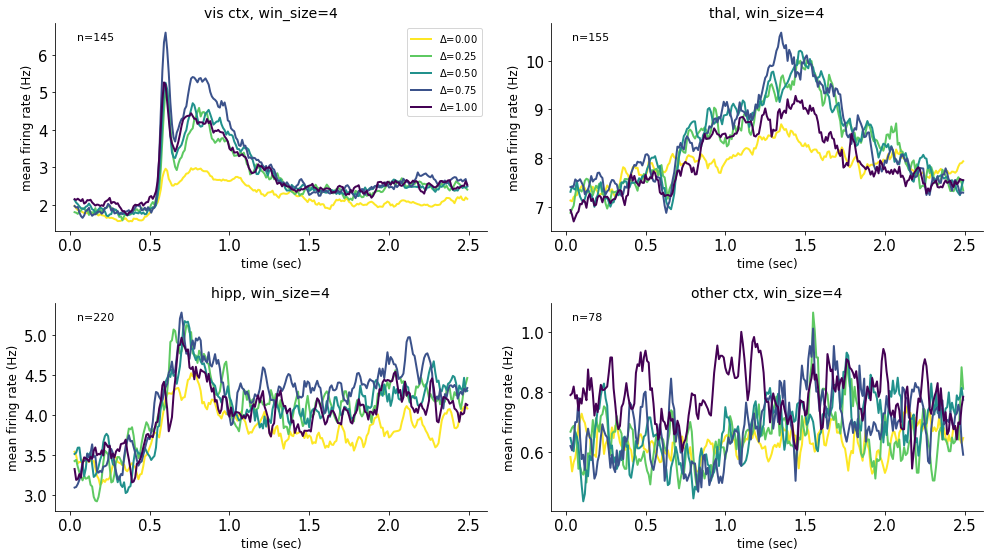

In [24]:
def plot_dcont(nareas, d_cont, dat):
    
#     fig = plt.figure(figsize=(15,3))
    fig = plt.figure(figsize=(14,8))
    for j in range(nareas):
        ax = plt.subplot(2,nareas//2,j+1)
#         ax = plt.subplot(1,nareas,j+1)

        win_size = 4
        colors = plt.cm.viridis(np.linspace(0,1,len(np.unique(d_cont))))
        for i, cont in enumerate(np.unique(d_cont)):
            plt.plot(dt * np.arange(NT), 
                     1/dt * pd.Series(dat['spks'][:,d_cont==cont][barea==j].mean(axis=(0,1))).rolling(window=win_size).mean(),
                    label=r'$\Delta$=%1.2f'%cont,
                    linewidth=2,
                    color=colors[len(np.unique(d_cont))-i-1])

        plt.text(.05, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes, fontsize=11)

        if j==0:
            plt.legend(loc=1,fontsize=10)
    #         plt.legend(loc='center left',bbox_to_anchor=(1,0.5),fontsize=12)
#         ax.set(xlabel = 'time (sec)', 
#                ylabel = 'mean firing rate (Hz)')
        plt.xlabel('time (sec)', fontsize=12)
        plt.ylabel('mean firing rate (Hz)', fontsize=12)
        plt.title(regions[j]+', win_size=%1.0f'%win_size, fontsize=14)

# dt, NT, d_cont, dd_cont, ddcont = get_contrast_diff(11)
plot_dcont(nareas, d_cont, dat)
hide_toggle()

## Total Contrast (l_cont + r_cont)

In [25]:
def get_total_contrast(n_session):
    dat, barea, NN, regions, brain_groups, nareas = load_data(n_session)
    
    dt = dat['bin_size'] # binning at 10 ms
    NT = dat['spks'].shape[-1]

    l_cont = dat['contrast_left']
    r_cont = dat['contrast_right']
    
    t_cont = np.abs(l_cont + r_cont)
    dt_cont = np.diff(t_cont)
    dtcont = np.insert(dt_cont, 0, 0)

    return dt, NT, t_cont, dt_cont, dtcont
# dt, NT, t_cont, dt_cont, dtcont = get_total_contrast(11)

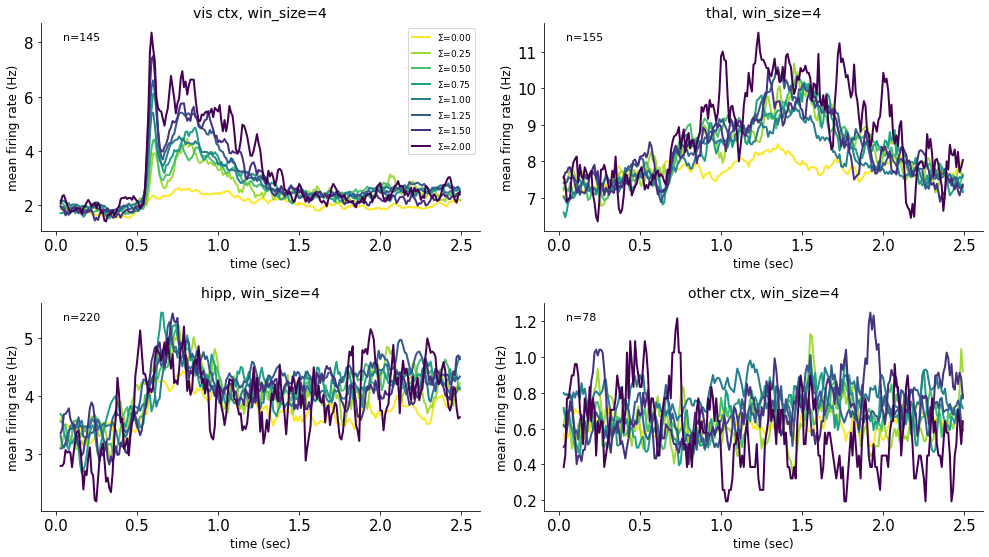

In [28]:
def plot_tcont(nareas, t_cont, dat):

    fig = plt.figure(figsize=(14,8))
#     fig = plt.figure(figsize=(15,3))
    for j in range(nareas):
        ax = plt.subplot(2,nareas//2,j+1)
        win_size = 4
        colors = plt.cm.viridis(np.linspace(0,1,len(np.unique(t_cont))))

        for i, cont in enumerate(np.unique(t_cont)):
            plt.plot(dt * np.arange(NT), 
                     1/dt * pd.Series(dat['spks'][:,t_cont==cont][barea==j].mean(axis=(0,1))).rolling(window=win_size).mean(),
                     color = colors[len(np.unique(t_cont))-i-1],
                     linewidth=2,
                     label=r'$\Sigma$=%1.2f'%cont) # difference 0

        plt.text(.05, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes, fontsize=11)

        if j==0:
            plt.legend(loc=1, fontsize=9)
    #         plt.legend(loc='center left', bbox_to_anchor=(1,0.5),fontsize=10)
#         ax.set(xlabel = 'time (sec)', ylabel = 'mean firing rate (Hz)')
        plt.xlabel('time (sec)', fontsize=12)
        plt.ylabel('mean firing rate (Hz)', fontsize=12)
        plt.title(regions[j]+', win_size=%1.0f'%win_size, fontsize=14)

dt, NT, t_cont, dt_cont, dtcont = get_total_contrast(11)
plot_tcont(nareas, t_cont, dat)
hide_toggle()

## Check session 7,8,11

In [ ]:
# for i, n_session in enumerate(np.array([7,8,11])):
for i, n_session in enumerate(np.array([8])):
    dat, barea, NN, regions, brain_groups, nareas = load_data(n_session)

    dt, NT, d_cont, dd_cont, ddcont = get_contrast_diff(n_session)
    plot_dcont(nareas, d_cont, dat)
    
    dt, NT, t_cont, dt_cont, dtcont = get_total_contrast(n_session)
    plot_tcont(nareas, t_cont, dat)

    print('session %1.0f'%n_session)
    print('--------------------------------')
    